## NLP Class Final Project Read Data

# Data Loading and Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import spacy
import nltk
nltk.download('vader_lexicon')

ModuleNotFoundError: No module named 'wordcloud'

In [3]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 9.78 s, sys: 11 s, total: 20.8 s
Wall time: 57.5 s


(200435, 5)

In [4]:
# Display basic information about the dataset
print(df_news_final_project.shape)
print(df_news_final_project.columns)
print(df_news_final_project.dtypes)
print(df_news_final_project.head())
print(df_news_final_project.isnull().sum())
print(df_news_final_project['text'].str.len().describe())

(200435, 5)
Index(['url', 'date', 'language', 'title', 'text'], dtype='object')
url         object
date        object
language    object
title       object
text        object
dtype: object
                                                 url        date language  \
0  http://galusaustralis.com/2020/02/486473/legal...  2020-02-26       en   
1  http://newsparliament.com/2020/02/27/children-...  2020-02-27       en   
2  http://www.agoravox.it/Covid-19-un-messaggio-d...  2020-03-13       en   
3  http://www.desototimes.com/news/child-actor-cl...  2022-06-09       en   
4  http://www.millenniumpost.in/big-stories/ai-ex...  2020-08-07       en   

                                               title  \
0  LegalTech Artificial Intelligence Market 2019 ...   
1  Children With Autism Saw Their Learning and So...   
2  Covid-19: un messaggio dai ricercatori italian...   
3  Child actor Claude Jarman Jr. looks back on hi...   
4  Two dead as AI Express flight skids off Kozhik...   

           

# Data Cleaning and Pre-Processing

In [5]:
nltk.download('stopwords')

import nltk

stopwords = nltk.corpus.stopwords.words('english')
import re


def clean_text(text):
    text = re.sub(r'[\n\t]', ' ', str(text))
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    return text

df_news_final_project['text'] = df_news_final_project['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_news_final_project

,url,date,language,title,text
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,legaltech artificial intelligence market 2019 ...
1,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,children autism saw learning social skills boo...
2,http://www.agoravox.it/Covid-19-un-messaggio-d...,2020-03-13,en,Covid-19: un messaggio dai ricercatori italian...,covid19 un messaggio dai ricercatori italiani ...
3,http://www.desototimes.com/news/child-actor-cl...,2022-06-09,en,Child actor Claude Jarman Jr. looks back on hi...,child actor claude jarman jr looks back movie ...
4,http://www.millenniumpost.in/big-stories/ai-ex...,2020-08-07,en,Two dead as AI Express flight skids off Kozhik...,two dead ai express flight skids kozhikode air...
...,...,...,...,...,...
200430,https://www.zdnet.com/article/google-cloud-exp...,2023-08-29,en,Google Cloud expands developer tools and data ...,google cloud expands developer tools data anal...
200431,https://yen.com.gh/business-economy/231589-twi...,2023-04-12,en,Twitter working on AI despite Musk call for gl...,twitter working ai despite musk call global pa...
200432,https://zeenews.india.com/companies/one-ai-kil...,2022-12-31,en,'One AI Killer app will emerge...': Nothing fo...,one ai killer app emerge nothing founder carl ...
200433,https://zeenews.india.com/technology/openai-re...,2023-04-29,en,OpenAI Restores Access To ChatGPT In Italy Aft...,openai restores access chatgpt italy ban techn...


# Topic Modeling

In [7]:
# Sample data
df_news_final_project = df_news_final_project.sample(20000, random_state=42)

# Topic modeling
cv = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
dtm = cv.fit_transform(df_news_final_project['text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# Top words for each topic
topic_words = []
n_top_words = 10
for topic in lda.components_:
    word_idx = topic.argsort()[:-n_top_words - 1:-1]
    topic_words.append([cv.get_feature_names_out()[i] for i in word_idx])

# Topic distributions
topic_dist = lda.transform(dtm)
topic_dist

array([[7.82656314e-05, 7.82614272e-05, 7.82633906e-05, ...,
        1.28458380e-01, 6.51506791e-01, 2.19486979e-01],
       [1.17585981e-01, 1.86660725e-02, 7.92076926e-01, ...,
        1.68375820e-04, 1.68387620e-04, 1.68385365e-04],
       [9.98024885e-02, 1.06979410e-04, 1.06972111e-04, ...,
        4.21862479e-03, 1.06973388e-04, 8.78389565e-01],
       ...,
       [1.43926655e-04, 1.43923826e-04, 1.43934020e-04, ...,
        1.60492724e-01, 4.46371043e-03, 3.40985917e-01],
       [1.60276948e-04, 1.60275411e-04, 1.60280307e-04, ...,
        1.60307756e-04, 9.98557449e-01, 1.60289505e-04],
       [3.63973806e-01, 1.32476336e-04, 6.34966358e-01, ...,
        1.32470551e-04, 1.32469188e-04, 1.32482287e-04]])

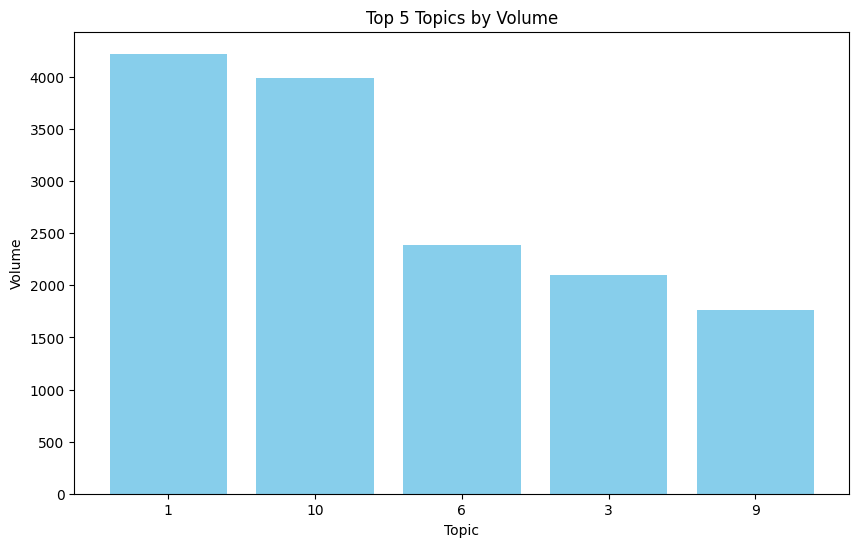

Topic 1:
1. ai
2. data
3. technology
4. gray
5. learning
6. media
7. group
8. new
9. platform
10. cloud

Topic 2:
1. ai
2. news
3. new
4. technology
5. 2023
6. media
7. law
8. south
9. industry
10. newswires

Topic 3:
1. ai
2. gray
3. republic
4. media
5. group
6. content
7. release
8. statements
9. company
10. press

Topic 4:
1. services
2. products
3. news
4. business
5. technology
6. entertainment
7. media
8. consumer
9. policy
10. general

Topic 5:
1. news
2. india
3. 2023
4. ai
5. business
6. openai
7. stocks
8. lg
9. altman
10. world

Topic 6:
1. ai
2. best
3. 2023
4. news
5. new
6. share
7. google
8. tech
9. price
10. microsoft

Topic 7:
1. market
2. report
3. global
4. intelligence
5. analysis
6. artificial
7. growth
8. ai
9. research
10. industry

Topic 8:
1. new
2. news
3. sports
4. home
5. email
6. video
7. star
8. said
9. facebook
10. years

Topic 9:
1. ago
2. news
3. hours
4. 2023
5. weather
6. public
7. stories
8. ai
9. video
10. search

Topic 10:
1. ai
2. news
3. said
4.

In [8]:
import matplotlib.pyplot as plt

# Bar chart with top 5 topics by volume
topic_volumes = topic_dist.sum(axis=0)
top_topics_indices = topic_volumes.argsort()[-5:][::-1]
top_topics_volumes = topic_volumes[top_topics_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), top_topics_volumes, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Volume')
plt.title('Top 5 Topics by Volume')
plt.xticks(range(1, 6), top_topics_indices + 1)
plt.show()

# List top terms for each topic with weights
for i, topic_words_list in enumerate(topic_words):
    print(f"Topic {i + 1}:")
    for j, word in enumerate(topic_words_list):
        print(f"{j + 1}. {word}")
    print()

# Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


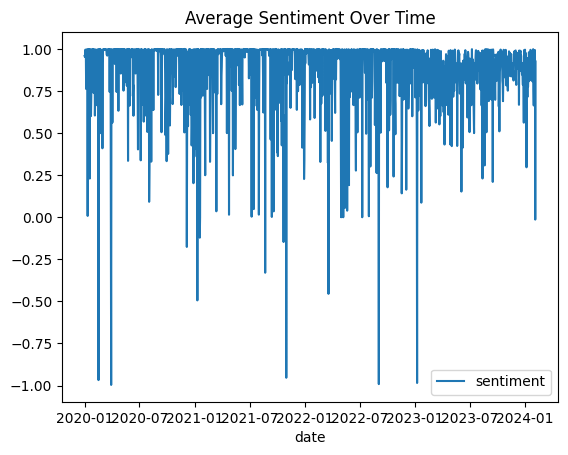

In [10]:
# Sentiment analysis
nltk.download('vader_lexicon') 
sid = SentimentIntensityAnalyzer()
df_news_final_project['sentiment'] = df_news_final_project['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

df_sentiment = df_news_final_project.groupby(['date'])['sentiment'].mean().reset_index()

ax = df_sentiment.plot(x='date', y='sentiment',
                       title='Average Sentiment Over Time')
fig = ax.get_figure()
fig.savefig('sentiment.png')

# AI Integration Analysis

In [11]:
# Entity extraction with spaCy
!python -m spacy download en_core_web_lg 
nlp = spacy.load('en_core_web_lg')
orgs = []
places = []
for text in df_news_final_project['text']:
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            orgs.append(ent.text)
        elif ent.label_ == 'GPE':
            places.append(ent.text)

top_orgs = pd.Series(orgs).value_counts()[:10]
top_places = pd.Series(places).value_counts()[:10]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


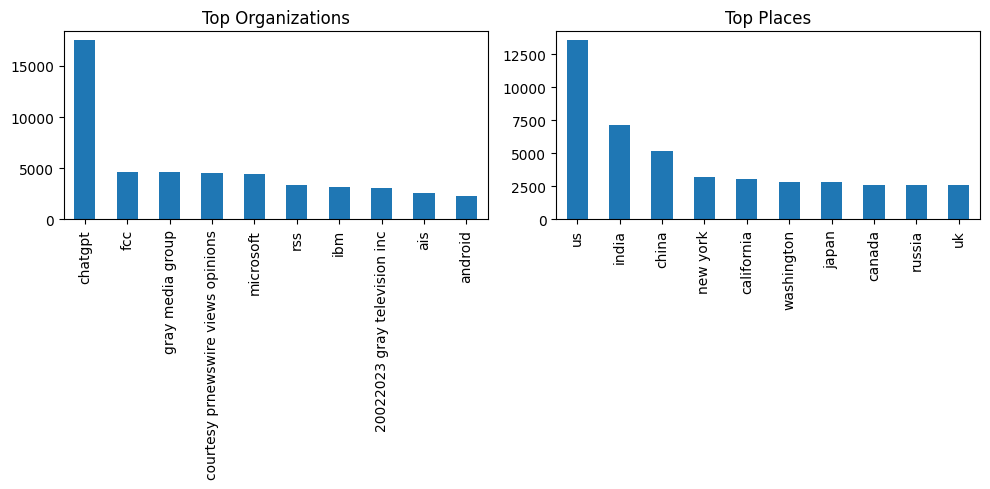

In [12]:
# Plot top organizations and locations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
top_orgs.plot.bar(ax=ax1)
ax1.set_title("Top Organizations")

top_places.plot.bar(ax=ax2)
ax2.set_title("Top Places")
plt.tight_layout()
plt.savefig('entities.png')

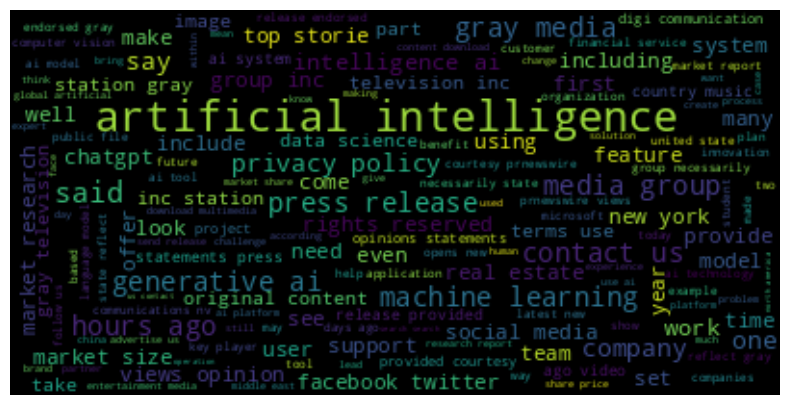

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud from text
def generate_wordcloud(text):
    wordcloud = WordCloud(width=400, height=200).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('success_cloud.png')

# Downsampling the data
df_pos_sampled = df_news_final_project[df_news_final_project['sentiment'] > 0.2].sample(frac=0.5) 

# Concatenating sampled text
text = " ".join(review for review in df_pos_sampled['text'])

# Generating word cloud
generate_wordcloud(text)


In [ ]:
# Function to generate word cloud from text
def generate_wordcloud(text, output_filename):
    wordcloud = WordCloud(width=400, height=200).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(output_filename)

# Downsampling the data for failures
df_neg_sampled = df_news_final_project[df_news_final_project['sentiment'] < -0.2].sample(frac=0.5)

# Concatenating sampled text for failures
text_failures = " ".join(review for review in df_neg_sampled['text'])

# Generating word cloud for failures
generate_wordcloud(text_failures, 'failure_cloud.png')

# Downsampling the data for success
df_pos_sampled = df_news_final_project[df_news_final_project['sentiment'] > 0.2].sample(frac=0.5)  

# Concatenating sampled text for success
text_success = " ".join(review for review in df_pos_sampled['text'])

# Generating word cloud for success
generate_wordcloud(text_success, 'success_cloud.png')
